我们喜欢回答学员的问题。因为一个好的问题，往往胜过一个好的答案。

!!! note "响应时间"
    很遗憾的是，我们没法承诺响应时间。就像有一个瓿提过来已经两个月了，我们还只进行了一部分。因为缺少相关的回测工具需要开发，还需要数据品种比较多，也需要理解和下载；此外，最后还要部署到环境中，存在临时才发现的各种兼容问题。
    但确实对不住学员。我们大概率会在这个月结束。

今天我们拿到的问题与量化看视无关，但其实非常相似，所以，我们也把它发表出来。

这个问题是，我有若干列的特征数据与目标变量。目标变量的取值为0和1，分别代表着正常和出错。现在，要求在出错时，参归因到是哪一列或者几列前几天的数据导致的。

看了学员举的几个判例之后，我发现这个问题没有确实解--就是没有确定的规律。我们先来看看它的数据（已脱敏）：

In [ ]:
import pandas as pd
import string

def rename_columns(data):
    start = 3
    orig_cols = list(data.columns)
    orig_tail = orig_cols[start:]

    tail_count = max(0, data.shape[1] - start)
    new_tail = list(string.ascii_uppercase[:tail_count]) 

    data.columns = ["start", "ECI", "y"] + new_tail

    letter_to_source = {new_tail[i]: orig_tail[i] for i in range(len(new_tail))}
    data.attrs['letter_to_source'] = letter_to_source
    return data

data = pd.read_excel(data_home/"ro/drama.xlsx")
df_ = rename_columns(data)
df_[["start", "y", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]].to_csv(data_home/"ro/drama.csv", index=False)


In [5]:

def expand_data(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n <= 0:
        base_cols = [c for c in ['start', 'y'] if c in df.columns]
        return df[base_cols].copy()

    cols = list(df.columns)
    if 'A' in cols:
        start_idx = cols.index('A')
        feat_cols = cols[start_idx:]
    else:
        # Fallback: uppercase letter-like column names in original order (A, B, ..., AA, AB, ...)
        feat_candidates = {c for c in cols if c.isalpha() and c.upper() == c}
        feat_cols = [c for c in cols if c in feat_candidates]

    base_cols = [c for c in ['start', 'y'] if c in df.columns]

    # Build lag features with vectorized shift (efficient, no Python loops over rows)
    out = {}
    for col in feat_cols:
        s = df[col]
        for k in range(1, n + 1):
            out[f'{col}_{k}'] = s.shift(k)

    features = pd.DataFrame(out, index=df.index)
    res = pd.concat([df[base_cols], features], axis=1)

    # Propagate and build decoding map for lagged features
    letter_to_source = df.attrs.get('letter_to_source', {})
    feature_decode = {}
    for col in feat_cols:
        src = letter_to_source.get(col, col)
        for k in range(1, n + 1):
            feature_decode[f'{col}_{k}'] = {'source': src, 'lag': k}
    res.attrs['letter_to_source'] = letter_to_source
    res.attrs['feature_decode'] = feature_decode
    trimmed = res.iloc[n:].reset_index(drop=True)
    trimmed.attrs['letter_to_source'] = letter_to_source
    trimmed.attrs['feature_decode'] = feature_decode
    return trimmed

df = pd.read_csv(data_home/"ro/drama.csv")
expand_data(df, 5)

,start,y,A_1,A_2,A_3,A_4,A_5,B_1,B_2,B_3,...,K_1,K_2,K_3,K_4,K_5,L_1,L_2,L_3,L_4,L_5
0,2025-08-24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-08-25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-08-26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-08-27,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-08-28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2025-08-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,2025-08-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,2025-08-31,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,2025-09-01,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,2025-09-02,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

def train_xgb_and_rank_features(
    df: pd.DataFrame,
    importance_type: str = "gain",  # 'gain' | 'weight' | 'cover' | 'total_gain' | 'total_cover'
    n_estimators: int = 400,
    max_depth: int = 5,
    learning_rate: float = 0.05,
    subsample: float = 0.8,
    colsample_bytree: float = 0.8,
    reg_lambda: float = 1.0,
    random_state: int = 42,
):
    """
    Train an XGBoost classifier and return sorted feature importances.
    - Features: all columns except [drop_cols + target_col]
    - Target: y (auto-encode to integers if not numeric)
    """
    # 1) Build X, y
    feat_cols = list(set(df.columns) - set(["y", "start"]))
    X = df[feat_cols].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df["y"], errors="ignore")

    # 2) Drop rows with NaN in X or y to ensure clean training data
    mask = X.notna().all(axis=1) & pd.notna(y)
    X, y = X.loc[mask], y.loc[mask]

    # 3) Encode non-numeric y to category codes for classification
    if not np.issubdtype(y.dtype, np.number):
        y = y.astype("category").cat.codes

    classes = np.unique(y)
    num_class = len(classes)
    objective = "binary:logistic" if num_class == 2 else "multi:softprob"

    # 4) Construct classifier (only set num_class when > 2)
    params = dict(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        objective=objective,
        eval_metric="logloss" if num_class == 2 else "mlogloss",
        n_jobs=0,
        tree_method="hist",
        random_state=random_state,
    )
    if num_class > 2:
        params["num_class"] = num_class

    clf = XGBClassifier(**params)
    clf.fit(X, y)

    return clf

clf = train_xgb_and_rank_features(df)
clf

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [8]:
def get_feature_importance(clf, df):
    booster = clf.get_booster()

    score = booster.get_score(importance_type="gain")  

    feat_columns = list(set(df.columns) - set(["y", "start"]))

    imp_df = pd.DataFrame([(name, score.get(name, 0.0)) for name in feat_columns],
                                columns=["feature", "importance"])
    imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

    return imp_df

get_feature_importance(clf, df)

,feature,importance
0,K,0.183588
1,I,0.000000
2,H,0.000000
3,E,0.000000
4,F,0.000000
5,L,0.000000
6,G,0.000000
7,C,0.000000
8,J,0.000000
9,D,0.000000


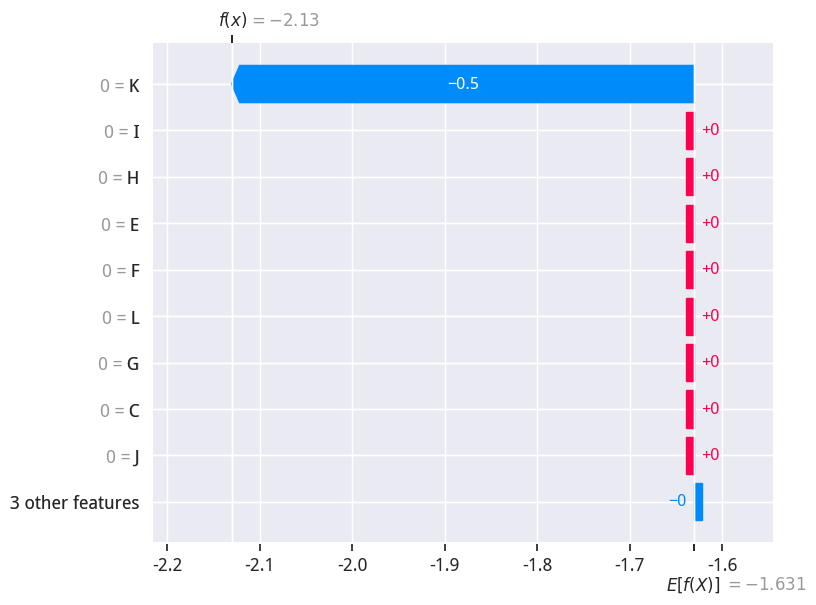

In [24]:
import shap

# 为Jupyter/Colab环境初始化JS可视化支持
shap.initjs()

# 1. 创建解释器
# TreeExplainer是针对树模型（如XGBoost）优化过的高效解释器
explainer = shap.TreeExplainer(clf)

# 2. 计算SHAP值
# 我们可以为整个数据集计算，也可以只为我们关心的单个样本计算
# 这里我们以数据集中最后一条记录（即宕机当天）为例
X_instance = X.iloc[-1:]
shap_values = explainer.shap_values(X_instance)

# 3. 可视化局部归因 - Waterfall图
# Waterfall图可以非常清晰地看到每个特征如何将预测从基线值推向最终值
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                    base_values=explainer.expected_value,
                                    data=X_instance.iloc[0],
                                    feature_names=X.columns.tolist()))

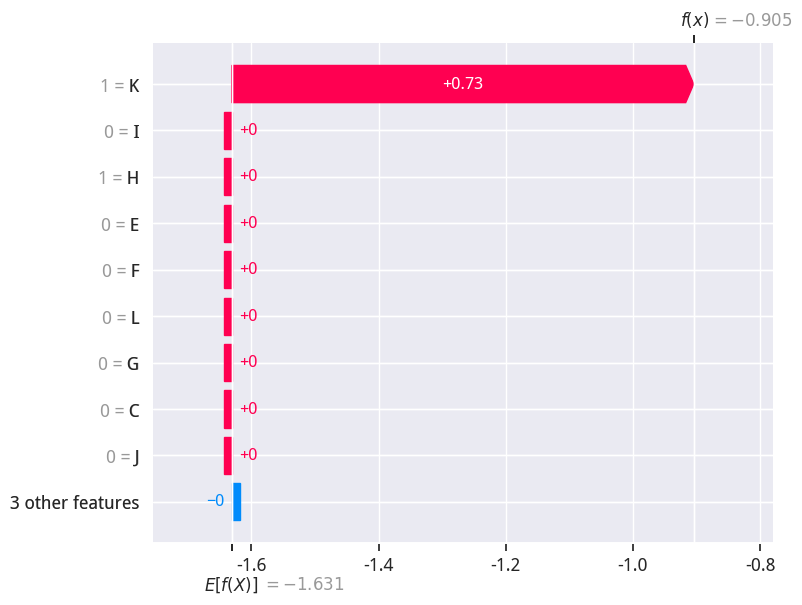

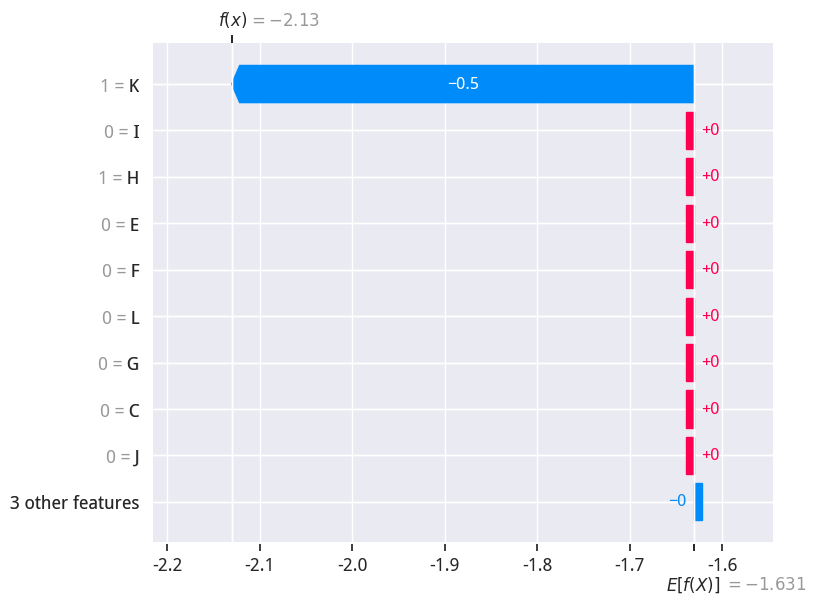

In [29]:
import shap

def explain(clf, Xi):
    shap.initjs()

    # 1. 创建解释器
    # TreeExplainer是针对树模型（如XGBoost）优化过的高效解释器
    explainer = shap.TreeExplainer(clf)

    # 2. 计算SHAP值
    shap_values = explainer.shap_values(Xi)

    # 3. 可视化局部归因 - Waterfall图
    shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                        base_values=explainer.expected_value,
                                        data=X_instance.iloc[0],
                                        feature_names=X.columns.tolist()))

# 倒数第二天，网站挂了
Xi = df[feat_columns][-2:-1]
explain(clf, Xi)

# 倒数第一天，网站没挂
Xi = df[feat_columns][-1:]
explain(clf, Xi)

<div style="display:flex">
<div>
<img src="https://cdn.jsdelivr.net/gh/zillionare/imgbed2@main/images/2025/08/positive-shap.png">
</div>
<div>
<img src="https://cdn.jsdelivr.net/gh/zillionare/imgbed2@main/images/2025/08/negative.png">
</div>
</div>

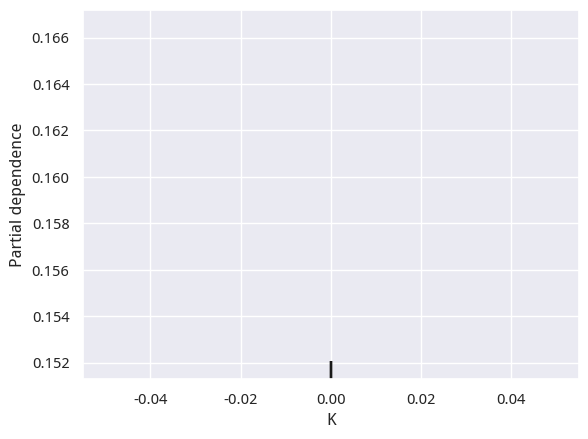

In [23]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 创建部分依赖图显示
disp = PartialDependenceDisplay.from_estimator(
    clf, X, features=['K'],
    feature_names=['K'],
    kind='average'
)
plt.show()